<a name="top"></a><img src="source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

  Before running Spinal HDL code, be sure to load SpinalHDL Libraries  
**Note** : This may be a little slow when the first time load, please wait a moment to download Lib from remote.)

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## AMBA-bus
### apb

The AMBA3-APB bus is commonly used to interface low bandwidth peripherals.
First each time you want to create a APB3 bus, you will need a configuration object.  

In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.misc._

class Top extends Component{
    val apbConfig = Apb3Config(
        addressWidth = 12,
        dataWidth    = 32,
        selWidth     = 2)
    val a = slave(Apb3(apbConfig))
    val b = master(Apb3(apbConfig))
    b <> a
}

showRtl(new Top)

Mem read and Write

In [ ]:
class Top extends Component{
    val apb = slave(Apb3(Apb3Config(8,32,2)))
    val slv = Apb3SlaveFactory(apb,1)  
    val regs = Vec(Reg(UInt(32 bits)) init 0 ,8)
    (0 until 8).map(i=>slv.readAndWrite(regs(i),address= i * 4 ))
}

showRtl(new Top)

### Apb3 address Mapping

#### Apb3Decoder 
it will decode out multiple PSEL signals
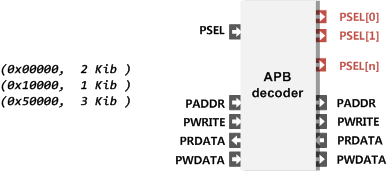

In [ ]:
showRtl(new Apb3Decoder(Apb3Config(16,32),List((0x00,20),
                                               (0x1000,1 KiB),
                                               (0x2000,1 KiB))))

#### ApbRouter   
APBRouter not only generates multiple PSELS, but also divides them into multiple bus interfaces.
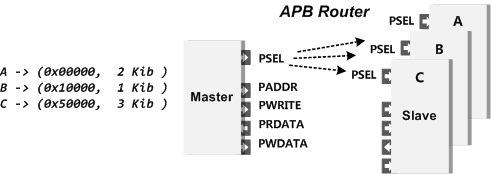

In [ ]:
showRtl(new Apb3Router(Apb3Config(16,32,3)))

In [ ]:
import spinal.lib.bus.amba3.apb._

class Top extends Component{    
    val din  =  slave(Apb3(Apb3Config(16,32)))
    val do1  = master(Apb3(Apb3Config( 8,32)))
    val do2  = master(Apb3(Apb3Config(12,32)))    
    val do3  = master(Apb3(Apb3Config(12,32)))      
    val do4  = master(Apb3(Apb3Config( 2,32)))
    
val mux = Apb3Decoder(master = din, 
                      slaves = List(do1 ->  (0x0000,  64 ),
                                    do2 ->  (0x1000,1 KiB),                                   
                                    do3 ->  (0x2000,2 KiB),                                   
                                    do4 ->  (0x3000,  32 )))
}
showRtl(new Top)                  

**Attation**：  
In the case of applying multiple matches, the implicit conversion needs to specify the parameter name, otherwise the implicit conversion will not succeed
```scala
val mux = Apb3Decoder(Apb3Config(16,32),
                      List((0x00000,64),(0x10000,64)))

implicit def implicitTuple1(that:(Int, Int)):SizeMapping = SizeMapping(that._1,that._2)
```
An error will be reported because the apb3decoder has multiple pattern matches (Scala implicit conversion cannot be nested). You do not know which one to match. The implicit conversion is not successful
```scala
object Apb3Decoder{
  def apply(inputConfig: Apb3Config, decodings: Seq[SizeMapping]): Apb3Decoder={...}
  def apply(master: Apb3, slaves: Seq[(Apb3, SizeMapping)]): Apb3Decoder = {...}
}
```
The correct way is to specify the parameter name (for compiler information)

```scala
val mux = Apb3Decoder(inputConfig = Apb3Config(16,32),
                      decodings = List((0x00000,64),(0x10000,64)))
```

**For pattern matching with only one apply, you can omit the parameter name**

## AHB-lite3
First each time you want to create a AHB-Lite3 bus, you will need a configuration object.

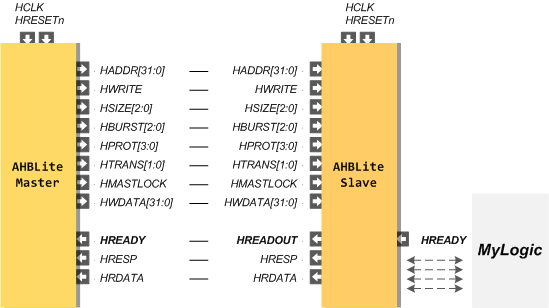

In [ ]:
import spinal.lib.bus.amba3.ahblite._

In [ ]:
class Top extends Component{    
  val ahbConfig = AhbLite3Config(
    addressWidth = 12,
    dataWidth    = 32
  )
  val ahbX = slave(AhbLite3(ahbConfig))
  val ahbY = slave(AhbLite3(ahbConfig))
  val ahbZ = master(AhbLite3(ahbConfig))
  ahbX.HRDATA := 0
  ahbY.HRDATA := 0
  ahbX.HREADYOUT := False
  ahbY.HREADYOUT := False
  ahbX.HRESP := False
  ahbY.HRESP := False    
  when(ahbY.HSEL){
    //...
      ahbZ <> ahbY
  }.otherwise{
      ahbZ <> ahbX
  }
}
showRtl(new Top)

#### AhbToApb3 Bridge


In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba3.ahblite._

class Top(ahbConfig:AhbLite3Config, apbConfig:Apb3Config) extends Component{
    val ahb = slave(AhbLite3(ahbConfig))
    val apb = master(Apb3(apbConfig))
    val bridge = AhbLite3ToApb3Bridge(ahbConfig,apbConfig)
    ahb <> bridge.io.ahb
    apb <> bridge.io.apb
}

showRtl(new Top(AhbLite3Config(16,32),Apb3Config(16,32)))

## AXI
### AXI crossBar
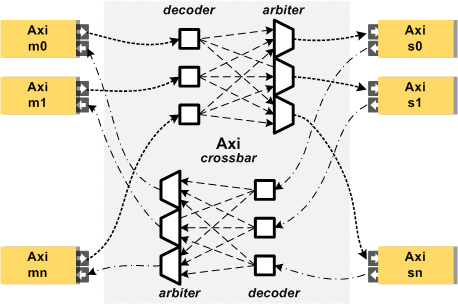

In [ ]:
import spinal.lib.bus.amba4.axi._ 

showRtl(Axi4SharedDecoder(
  axiConfig = Axi4Config(16,32,4),
  readDecodings = List((0x0000, 64    ),
                       (0x1000, 1 KiB ),
                       (0x2000, 3 KiB )),
  writeDecodings = List((0x3000, 3 KiB ),
                        (0x4000, 3 KiB )), 
  sharedDecodings = List((0x5000, 2 KiB),
                         (0x6000, 1 KiB) )
))

 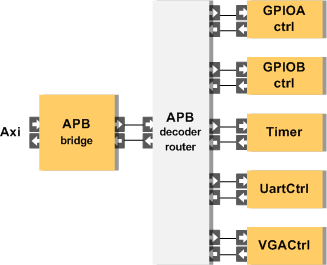


In [ ]:
import spinal.lib.bus.amba3.apb._
import spinal.lib.bus.amba4.axi._

class Top(aw: Int,dw: Int,iw: Int) extends Component{
  val axi = slave(Axi4Shared(Axi4Config(aw,dw,iw)))
  val apb = master(Apb3(Apb3Config(aw,dw)))
  val bridge = Axi4SharedToApb3Bridge(aw,dw,iw)
  axi <> bridge.io.axi
  apb <> bridge.io.apb
}

showRtl(new Top(20,32,2))

## Address-Mapping
### Bram-bus address allocate

 /** Address incrementation used by the read and write multi words registers */  
  def wordAddressInc: Int = busDataWidth / 8
  
  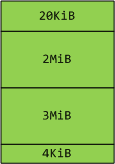

In [ ]:
import spinal.lib.bus.bram._
//showRtl(new BRAMDecoder(BRAMConfig(32,16),List((0x00,20),(0x1000,1 MiB))))
class Top extends Component{    
    val din  = slave(BRAM(BRAMConfig(32,16)))
    val do1  = master(BRAM(BRAMConfig(32, 8)))
    val do2  = master(BRAM(BRAMConfig(32,12)))    
    val do3  = master(BRAM(BRAMConfig(32,12)))      
    val do4  = master(BRAM(BRAMConfig(32,2)))
    
val brammux = BRAMDecoder(din, List(do1 ->  (0x00,  4 KiB ),
                                    do2 ->  (0x1000,3 MiB),                                   
                                    do3 ->  (0x2000,2 MiB),                                   
                                    do4 ->  (0x3000,20 KiB)))  
}
showRtl(new Top)

In [ ]:
import spinal.lib.bus.bram._
//showRtl(new BRAMDecoder(BRAMConfig(32,16),List((0x00,20),(0x1000,1 MiB))))
class Top(w: Int) extends Component{    
    val din  = slave(BRAM(BRAMConfig(w,12)))
    val do1  = master(BRAM(BRAMConfig(w,10)))
    val do2  = master(BRAM(BRAMConfig(w,10))) 
    
val brammux = BRAMDecoder(din, List(do1 ->  (0x00000,1 KiB),
                                    do2 ->  (0x10000,3 KiB))) 
}
showRtl(new Top(8))